# Modeling Short Time Series with Prior Knowledge in PyMC

**Source:** [Modeling Short Time Series with Prior Knowledge](https://minimizeregret.com/short-time-series-prior-knowledge)

## Prepare Notebook

In [1]:
import aesara
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
from pymc.distributions.continuous import Exponential
from sklearn.preprocessing import StandardScaler
import seaborn as sns


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.9/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/docs/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.9/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Read Data

In [2]:
raw_df = pd.read_csv("../data/sales.csv", parse_dates=["date"])

raw_df.head()

,date,sales,temp
0,2013-07-01,57.0,303.0
1,2013-07-02,58.0,298.0
2,2013-07-03,53.0,301.0
3,2013-07-04,36.0,302.0
4,2013-07-05,29.0,305.0


## EDA

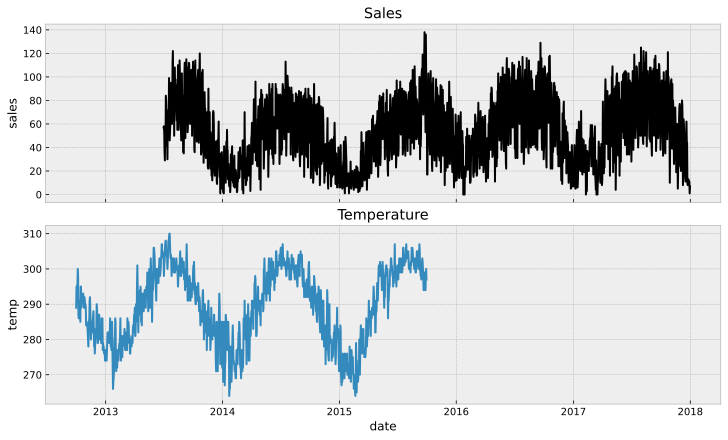

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True, sharey=False, layout="constrained")
sns.lineplot(x="date", y="sales", data=raw_df, color="black", ax=ax[0])
sns.lineplot(x="date", y="temp", data=raw_df, color="C0", ax=ax[1])
ax[0].set(title="Sales")
ax[1].set(title="Temperature");

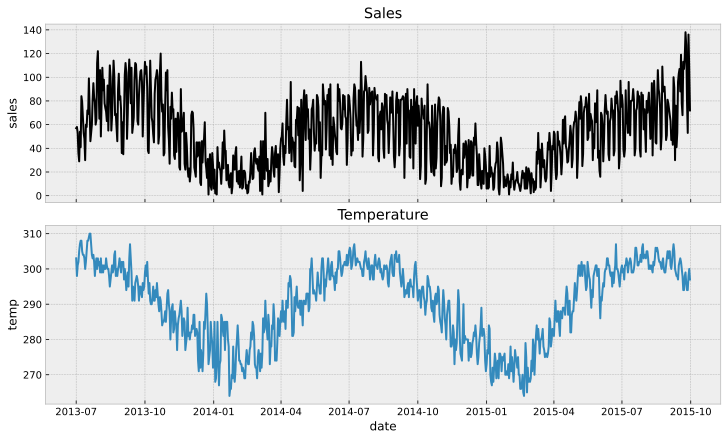

In [4]:
mask = "sales.notnull() and temp.notnull()"

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True, sharey=False, layout="constrained")
sns.lineplot(x="date", y="sales", data=raw_df.query(mask), color="black", ax=ax[0])
sns.lineplot(x="date", y="temp", data=raw_df.query(mask), color="C0", ax=ax[1])
ax[0].set(title="Sales")
ax[1].set(title="Temperature");

In [5]:
df = raw_df.query("temp.notnull()").sort_values("date").reset_index(drop=True).copy()

train_test_date = pd.to_datetime("'2013-10-15'")

df_train = df.query("date < @train_test_date & sales.notnull()")
df_test = df.query("date >= @train_test_date")

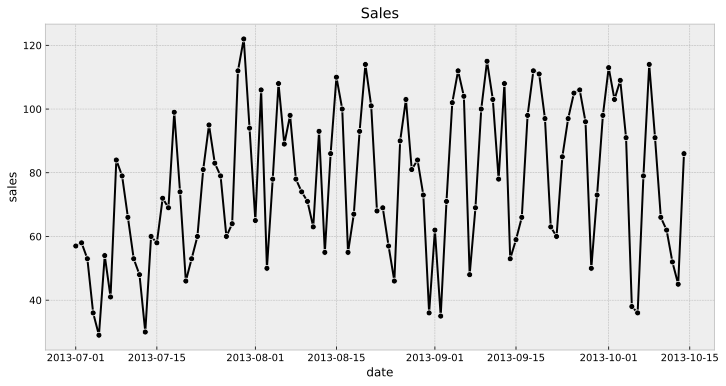

In [6]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="sales", data=df_train, color="black", marker="o", ax=ax)
ax.set(title="Sales");

## Temperature Model

In [7]:
date = df["date"]
df = df.eval("temp_scaled = temp - temp.min()")
temp_scaled = df["temp_scaled"]

In [8]:
periods = df["date"].dt.dayofyear / 365.25
n_order = 6

fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

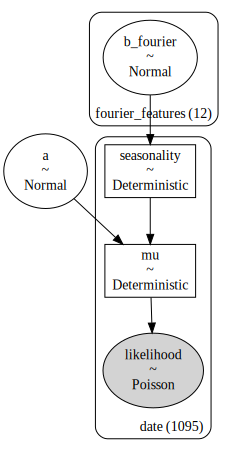

In [9]:
coords = {
    "date": date,
    "fourier_features": np.arange(2 * n_order),
}

with pm.Model(coords=coords) as temp_model:
    # --- priors ---
    ## intercept
    a = pm.Normal(name="a", mu=0, sigma=1)
    ## seasonality
    b_fourier = pm.Normal(name="b_fourier", mu=0, sigma=1, dims="fourier_features")
    # --- model parametrization ---
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(b_fourier, fourier_features.to_numpy().T), dims="date"
    )
    mu = pm.Deterministic(name="mu", var= a + seasonality, dims="date")

    # --- likelihood ---
    pm.Poisson("likelihood", mu=pm.math.exp(mu), observed=temp_scaled, dims="date")

pm.model_to_graphviz(temp_model)

In [10]:
with temp_model:
    temp_prior_predictive = pm.sample_prior_predictive(samples=1000)

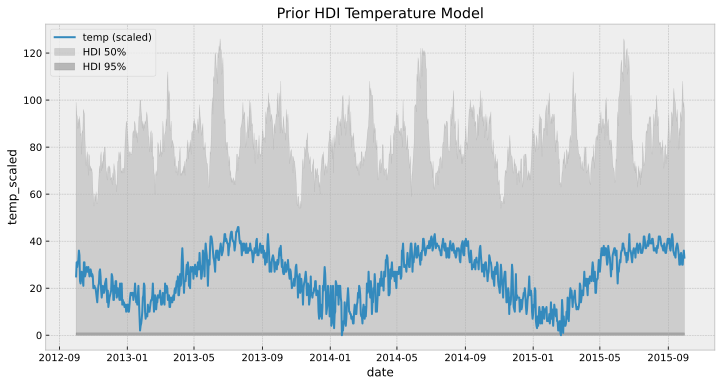

In [11]:
fig, ax = plt.subplots()

sns.lineplot(
    x="date", y="temp_scaled", data=df, color="C0", label="temp (scaled)", ax=ax
)
az.plot_hdi(
    x=date,
    y=temp_prior_predictive.prior_predictive["likelihood"],
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=temp_prior_predictive.prior_predictive["likelihood"],
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Prior HDI Temperature Model");

In [12]:
with temp_model:
    temp_idata = pm.sampling_jax.sample_numpyro_nuts(
        target_accept=0.9, draws=4000, chains=4
    )
    temp_posterior_predictive = pm.sample_posterior_predictive(trace=temp_idata)

Compiling...
Compilation time =  0:00:05.080179
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:03.821014
Transforming variables...
Transformation time =  0:00:00.159990
Computing Log Likelihood...
Log Likelihood time =  0:00:01.215781


In [13]:
az.summary(data=temp_idata, var_names=["a", "b_fourier"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,3.146,0.007,3.133,3.158,0.0,0.0,19693.0,12525.0,1.0
b_fourier[0],-0.248,0.009,-0.265,-0.231,0.0,0.0,20158.0,12594.0,1.0
b_fourier[1],-0.547,0.009,-0.565,-0.530,0.0,0.0,17933.0,13279.0,1.0
b_fourier[2],-0.122,0.009,-0.140,-0.105,0.0,0.0,16982.0,12770.0,1.0
b_fourier[3],-0.049,0.009,-0.066,-0.032,0.0,0.0,17867.0,12946.0,1.0
b_fourier[4],-0.046,0.009,-0.065,-0.029,0.0,0.0,18707.0,13074.0,1.0
b_fourier[5],0.047,0.009,0.030,0.065,0.0,0.0,17595.0,13143.0,1.0
b_fourier[6],-0.005,0.009,-0.022,0.013,0.0,0.0,18271.0,12880.0,1.0
b_fourier[7],0.046,0.009,0.028,0.063,0.0,0.0,18322.0,12188.0,1.0
b_fourier[8],-0.000,0.009,-0.018,0.016,0.0,0.0,18516.0,13450.0,1.0


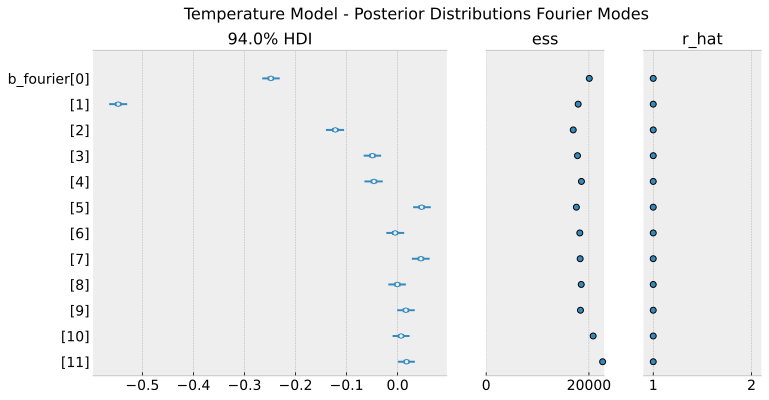

In [14]:
ax = az.plot_forest(
    data=temp_idata,
    var_names=["b_fourier"],
    combined=True,
    r_hat=True,
    ess=True,
    figsize=(12, 6),
)
plt.gcf().suptitle(
    "Temperature Model - Posterior Distributions Fourier Modes", fontsize=16
);

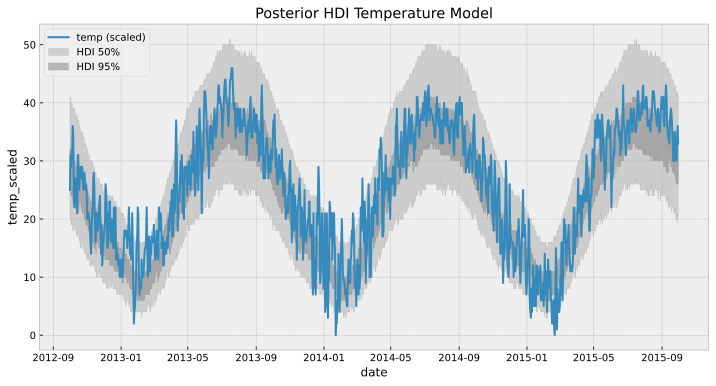

In [15]:
fig, ax = plt.subplots()

sns.lineplot(
    x="date", y="temp_scaled", data=df, color="C0", label="temp (scaled)", ax=ax
)
az.plot_hdi(
    x=date,
    y=temp_posterior_predictive.posterior_predictive["likelihood"],
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=temp_posterior_predictive.posterior_predictive["likelihood"],
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Posterior HDI Temperature Model");

## Sales Model

In [16]:
date_train = df_train["date"]
sales_train = df_train["sales"]

In [17]:
temp_model_summary = az.summary(data=temp_idata, var_names=["a", "b_fourier"])
a_loc = temp_model_summary[temp_model_summary.index == "a"]["mean"]
a_sd = temp_model_summary[temp_model_summary.index == "a"]["sd"]
fourier_loc = temp_model_summary[temp_model_summary.index != "a"]["mean"]
fourier_sd = temp_model_summary[temp_model_summary.index != "a"]["sd"]

In [18]:
periods_train = df_train["date"].dt.dayofyear / 365.25
n_order = 6

fourier_features_train = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods_train * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

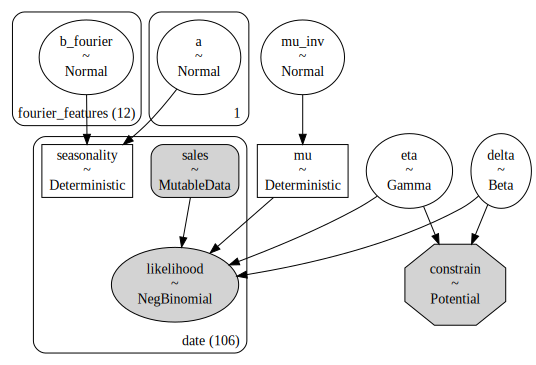

In [64]:
coords = {
    "date": date_train,
    "fourier_features": np.arange(2 * n_order),
}

with pm.Model(coords=coords) as sales_model:
    # --- data containers ---
    sales_data = pm.MutableData(name="sales", value=sales_train, dims="date")
    # --- priors ---
    delta = pm.Beta(name="delta", alpha=1, beta=10)
    eta = pm.Gamma(name="eta", alpha=0.5, beta=10)
    a = pm.Normal(name="a", mu=a_loc, sigma=a_sd)
    b_fourier = pm.Normal(
        name="b_fourier", mu=fourier_loc, sigma=fourier_sd, dims="fourier_features"
    )
    mu_inv = pm.Normal(name="mu_inv", mu=0, sigma=0.5)
    # --- model parametrization ---
    seasonality = pm.Deterministic(
        "seasonality",
        a + pm.math.dot(b_fourier, fourier_features_train.to_numpy().T),
        dims="date",
    )

    pm.Potential(
        name="constrain", var=at.switch(eta >= 1 - delta, -np.inf, 0)
    ),


    alpha0 = at.zeros(sales_data.shape[0])
    alpha0 = at.set_subtensor(alpha0[0], sales_data[0])

    def one_step(seasonality_t, sales_tm1, alpha_tm1, delta, eta):
        return (1 - delta - eta) * seasonality_t + delta * alpha_tm1 + eta * sales_tm1

    outputs, _ = aesara.scan(
        fn=one_step,
        sequences=[dict(input=seasonality), dict(input=sales_data, taps=[-1])],
        outputs_info=dict(initial=alpha0, taps=[-1]),
        non_sequences=[delta, eta],
        strict=True
    )

    alpha = at.set_subtensor(alpha0[1:], outputs[:, -1])

    mu = pm.Deterministic(name="mu", var=1 / pm.math.sqr(mu_inv))
    # --- likelihood ---
    pm.NegativeBinomial(
        name="likelihood", alpha=alpha, mu=mu, observed=sales_data, dims="date"
    )

pm.model_to_graphviz(sales_model)


In [59]:
def one_step(seasonality_t, sales_tm1, alpha_tm1, delta, eta):
        return (1 - delta - eta) * seasonality_t + delta * alpha_tm1 + eta * sales_tm1

outputs, _ = aesara.scan(
    fn=one_step,
    sequences=[dict(input=seasonality), dict(input=sales_data, taps=[-1])],
    outputs_info=dict(initial=alpha, taps=[-1]),
    non_sequences=[delta, eta],
    strict=True
)

outputs[:, -1].eval()
at.set_subtensor(alpha[1:], outputs[:, -1]).eval().shape

(106,)

In [61]:
with sales_model:
    sales_prior_predictive = pm.sample_prior_predictive(samples=1000)

/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_2375/2852363265.py:2: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  sales_prior_predictive = pm.sample_prior_predictive(samples=1000)


In [62]:
with sales_model:
    sales_idata = pm.sample(
        target_accept=0.9, draws=4000, chains=4
    )
    sales_posterior_predictive = pm.sample_posterior_predictive(trace=sales_idata)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, eta, a, b_fourier, mu_inv]
INFO:pymc:NUTS: [delta, eta, a, b_fourier, mu_inv]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 181 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 181 seconds.
/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_2375/3570660804.py:5: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  sales_posterior_predictive = pm.sample_posterior_predictive(trace=sales_idata)


In [63]:
az.summary(data=sales_idata, var_names=["a", "b_fourier"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],3.146,0.007,3.133,3.160,0.0,0.0,22985.0,11818.0,1.0
b_fourier[0],-0.248,0.009,-0.265,-0.231,0.0,0.0,21338.0,12735.0,1.0
b_fourier[1],-0.547,0.009,-0.563,-0.530,0.0,0.0,30707.0,11808.0,1.0
b_fourier[2],-0.122,0.009,-0.139,-0.105,0.0,0.0,20912.0,12265.0,1.0
b_fourier[3],-0.049,0.009,-0.066,-0.032,0.0,0.0,24261.0,11827.0,1.0
b_fourier[4],-0.046,0.009,-0.063,-0.029,0.0,0.0,24583.0,12575.0,1.0
b_fourier[5],0.047,0.009,0.030,0.064,0.0,0.0,24984.0,11790.0,1.0
b_fourier[6],-0.005,0.009,-0.022,0.012,0.0,0.0,23853.0,12675.0,1.0
b_fourier[7],0.046,0.009,0.029,0.063,0.0,0.0,26748.0,11359.0,1.0
b_fourier[8],-0.000,0.009,-0.018,0.016,0.0,0.0,23118.0,12442.0,1.0
